In [1]:
import torch
from torch.nn import Parameter

from lafomo.gp.variational.models import VariationalLFM
from lafomo.gp.variational.trainer import P53ConstrainedTrainer
from lafomo.gp.variational.options import VariationalOptions
from lafomo.utilities import save, load
from lafomo.plot.variational_plotters import Plotter

from matplotlib import pyplot as plt

In [2]:
from lafomo.data_loaders.datasets import TranscriptomicDataset
from os import path
import numpy as np
class SingleCellKidney(TranscriptomicDataset):
    """
    scRNA-seq dataset on the human kidney.
    Accession number: GSE131685
    """
    def __init__(self, replicate=None, data_dir='/Volumes/ultra/genomics/scRNA-seq/GSE131685_RAW_kidney/velocyto'):
        super().__init__()
        import scvelo as scv
        kidney1 = path.join(data_dir, 'kidney1.loom')
        data = scv.read_loom(kidney1)
        scv.pp.filter_and_normalize(data, min_shared_counts=20, n_top_genes=2000)
        self.loom = data
        self.gene_names = self.loom.var.index
        u = data.layers['unspliced']
        s = data.layers['spliced']
        self.data = np.concatenate([u.toarray(), s.toarray()], axis=1)
        num_cells = self.data.shape[0]
        self.data = torch.tensor(self.data.swapaxes(0, 1).reshape(4000, 1, num_cells))
        self.m_observed = self.data.permute(1, 0, 2)

        self.data = list(self.data)
dataset = SingleCellKidney()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 32289 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


In [3]:
print(dataset.m_observed.shape)
print(dataset.loom.var.index.shape)
print(dataset[0].shape)

torch.Size([1, 4000, 8164])
(2000,)
torch.Size([1, 8164])


In [4]:
from lafomo.data_loaders import LFMDataset
class RNAVelocityLFM(VariationalLFM):
    def __init__(self, num_genes, num_latents, t_inducing, dataset: LFMDataset, options: VariationalOptions, **kwargs):
        super().__init__(num_genes*2, num_latents, t_inducing, dataset, options, **kwargs)
        self.transcription_rate = Parameter(torch.rand((num_genes, 1), dtype=torch.float64))
        self.splicing_rate = Parameter(torch.rand((num_genes, 1), dtype=torch.float64))
        self.decay_rate = Parameter(0.1 + torch.rand((num_genes, 1), dtype=torch.float64))
        self.num_cells = dataset[0][0].shape[0]
        ### Initialise random time assignments
        self.time_assignments = torch.rand(self.num_cells, requires_grad=False)

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)
        num_samples = h.shape[0]
        num_outputs = h.shape[1]
        h = h.view(num_samples, num_outputs//2, 2)
        u = h[:, :, 0].unsqueeze(-1)
        s = h[:, :, 1].unsqueeze(-1)
        du = self.transcription_rate - self.splicing_rate * u
        ds = self.splicing_rate * u - self.decay_rate * s

        # q_f = self.get_latents(t.reshape(-1))
        # # Reparameterisation trick
        # f = q_f.rsample([self.num_samples])  # (S, I, t)
        # f = self.G(f)  # (S, num_outputs, t)

        h_t = torch.cat([du, ds], dim=1)

        return h_t

    def G(self, f):
        """
        Parameters:
            f: (I, T)
        """
        return f

    def predict_f(self, t_predict):
        # Sample from the latent distribution
        q_f = self.get_latents(t_predict.reshape(-1))
        f = q_f.sample([500])  # (S, I, t)
        # This is a hack to wrap the latent function with the nonlinearity. Note we use the same variance.
        f = torch.mean(self.G(f), dim=0)[0]
        return torch.distributions.multivariate_normal.MultivariateNormal(f, scale_tril=q_f.scale_tril)

In [5]:
from torch.utils.data import DataLoader
import numpy as np
from lafomo.utilities import is_cuda
from lafomo.gp.variational.trainer import Trainer
class EMTrainer(Trainer):
    """
    Expectation-Maximisation Trainer

    Parameters
    ----------
    model: .
    optimizer:
    dataset: Dataset where t_observed (T,), m_observed (J, T).
    inducing timepoints.
    give_output: whether the trainer should give the first output (y_0) as initial value to the model `forward()`
    """
    def __init__(self, model: RNAVelocityLFM, optimizer: torch.optim.Optimizer, dataset, batch_size=1, give_output=False):
        super().__init__(model, optimizer, dataset, batch_size, give_output)
        # Initialise trajectory
        self.timepoint_choices = torch.linspace(0, 1, 100, requires_grad=False)
        initial_value = self.initial_value(None)
        self.previous_trajectory = model(self.timepoint_choices, initial_value, rtol=1e-3, atol=1e-4)

    def initial_value(self, y):
        initial_value = torch.zeros((self.batch_size, 1), dtype=torch.float64)
        initial_value = initial_value.cuda() if is_cuda() else initial_value
        if self.give_output:
            initial_value = y[0]
        return initial_value.repeat(self.model.num_samples, 1, 1)  # Add batch dimension for sampling

    def single_epoch(self, rtol, atol):
        epoch_loss = 0
        epoch_ll = 0
        epoch_kl = 0
        for i, data in enumerate(self.data_loader):
            self.optimizer.zero_grad()
            y = data
            t = t.cuda() if is_cuda() else t
            y = y.cuda() if is_cuda() else y
            # Assume that the batch of t s are the same
            t, y = t[0].view(-1), y

            ### E-step ###
            # assign timepoints $t_i$ to each cell by minimising its distance to the trajectory
            num_outputs = self.model.num_outputs
            u = self.previous_trajectory[:num_outputs//2]
            s = self.previous_trajectory[num_outputs//2:]
            print(u.shape, s.shape, y.shape)
            # y shape (
            norm = (self.previous_trajectory - y)
            ### M-step ###
            initial_value = self.initial_value(y)
            output = self.model(t, initial_value, rtol=rtol, atol=atol)
            output = torch.squeeze(output)
            # Calc loss and backprop gradients
            mult = 1
            if self.num_epochs <= 10:
                mult = self.num_epochs/10

            ll, kl = self.model.elbo(y, output, mult, data_index=i)
            total_loss = -ll + kl
            total_loss.backward()
            self.optimizer.step()
            epoch_loss += total_loss.item()
            epoch_ll += ll.item()
            epoch_kl += kl.item()
        return epoch_loss, epoch_ll, epoch_kl

    def train(self, epochs=20, report_interval=1, plot_interval=20, rtol=1e-5, atol=1e-6):
        losses = list()
        end_epoch = self.num_epochs+epochs
        plt.figure(figsize=(4, 2.3))

        for epoch in range(epochs):
            epoch_loss, epoch_ll, epoch_kl = self.single_epoch(rtol, atol)


            if (epoch % report_interval) == 0:
                print('Epoch %d/%d - Loss: %.2f (%.2f %.2f) λ: %.3f' % (
                    self.num_epochs + 1, end_epoch,
                    epoch_loss, -epoch_ll, epoch_kl,
                    self.model.kernel.lengthscale[0].item(),
                ), end='')
                self.print_extra()

            losses.append((-epoch_ll, epoch_kl))
            self.after_epoch()

            if (epoch % plot_interval) == 0:
                plt.plot(self.t_observed, output[0].cpu().detach().numpy(), label='epoch'+str(epoch))
            self.num_epochs += 1
        plt.legend()

        losses = np.array(losses)
        self.losses = np.concatenate([self.losses, losses], axis=0)

        return output

    def print_extra(self):
        print('')

    def after_epoch(self):
        pass


In [8]:
options = VariationalOptions(
    learn_inducing=False,
    num_samples=50,
    kernel_scale=False
)
num_cells = dataset[0].shape[1]
print(num_cells)
t_inducing = torch.linspace(0, 1, 10, dtype=torch.float64).reshape((-1, 1))
t_observed = torch.linspace(0, 12, num_cells).view(-1)
t_predict = torch.linspace(-1, 13, 80, dtype=torch.float64)
model = RNAVelocityLFM(2000, 1, t_inducing, dataset, options)

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
trainer = EMTrainer(model, optimizer, dataset, batch_size=4000)
plotter = Plotter(model, dataset.gene_names)

8164


### Outputs prior to training:

(tensor([[[ 0.0000e+00,  3.7026e-03,  7.2158e-03,  ...,  7.1063e-02,
            7.1127e-02,  7.1189e-02],
          [ 0.0000e+00,  8.7016e-02,  1.5228e-01,  ...,  4.6229e+01,
            4.8482e+01,  5.0784e+01],
          [ 0.0000e+00,  1.4529e-01,  2.8047e-01,  ..., -1.3720e+01,
           -1.4053e+01, -1.4373e+01],
          ...,
          [ 0.0000e+00, -1.3389e-11, -9.4013e-11,  ...,  1.4333e+03,
            1.6658e+03,  1.9357e+03],
          [ 0.0000e+00,  6.1605e-12,  4.3187e-11,  ..., -4.0458e+03,
           -4.6966e+03, -5.4429e+03],
          [ 0.0000e+00,  3.7919e-14,  2.6667e-13,  ..., -6.7210e+03,
           -7.8260e+03, -9.0952e+03]],
 
         [[ 0.0000e+00,  1.1416e-01,  2.1833e-01,  ..., -7.6264e+01,
           -8.2371e+01, -8.8777e+01],
          [ 0.0000e+00,  1.6786e-01,  3.2063e-01,  ..., -2.0855e+02,
           -2.2464e+02, -2.4199e+02],
          [ 0.0000e+00,  1.5556e-01,  2.9613e-01,  ..., -2.8565e+02,
           -3.0101e+02, -3.1695e+02],
          ...,
    

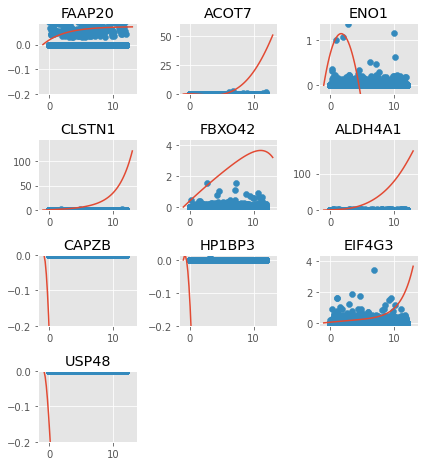

In [9]:
rtol = 1e-3
atol = rtol/10

model_kwargs = {
    'rtol': rtol, 'atol': atol
}

plotter.plot_outputs(t_predict, replicate=0, t_scatter=t_observed,y_scatter=dataset.m_observed, model_kwargs=model_kwargs)
# plotter.plot_latents(t_predict, ylim=(-1, 3), plot_barenco=True, plot_inducing=False)

In [10]:
tol = 5e-3
import time
start = time.time()

output = trainer.train(1, rtol=tol, atol=tol/10,
                       report_interval=5, plot_interval=5)
end = time.time()
print(end - start)


ValueError: too many values to unpack (expected 2)

<Figure size 288x165.6 with 0 Axes>

### Outputs after training

In [ ]:
plotter.plot_losses(trainer, last_x=100)
plotter.plot_outputs(t_predict, replicate=0, ylim=(0, 3), t_scatter=t_observed,y_scatter=m_observed, model_kwargs=model_kwargs)
plotter.plot_latents(t_predict, ylim=(-2, 4), plot_barenco=True, plot_inducing=False)
plotter.plot_kinetics()
plotter.plot_convergence(trainer)

In [ ]:
save(model, 'variational_linear')

In [ ]:
do_load = False
if do_load:
    model = load('variational_linear', SingleLinearLFM, num_genes, num_tfs,
                 t_inducing, dataset, extra_points=2, fixed_variance=dataset.variance)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    trainer = P53ConstrainedTrainer(model, optimizer, dataset)
print(do_load)